In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.autograd import Variable

import torch.utils.data as dataset
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.tensor as tensor
from tqdm import tqdm
import seaborn as sns

import model_file
import module_split as module
import RF_module as RF
import scipy.io as sio


#### GOAL: To train on synthetic data. This means, the image is multiplied with RF gaussians to create brain signal. 

In [2]:

def load_ydata():
    '''
    
    Loads targets.
    
    ------------------
    These are himages from the old testing dataset before splitting. Now since the data is slit, use only this one and not testing
    cropped images. 
    
    '''

    targets = np.load(f'../recetpivefield_stuff/cropped_images_training.npy')

    return targets

def load_gausdata():
    
    ''' 
    
    Load all necessary items for creating inputs for the model. 
    Inputs for the model will be signals * multivariate gaussian RFs. T
    he targets will be just the images seen by the monkey. returns gaus
    '''
    
    # Receptive_field fitted with multivariate function (2D)
    gaus_raw = np.load('../recetpivefield_stuff/multivariate_gaussians240_cropped.npy') # (192 x 240 x 240) is the shape
    gaus = np.concatenate([gaus_raw[:144], gaus_raw[145:]]) #takes away the ones with respective Nan electrode (elec # = 144) in LFP data
    gaus = torch.from_numpy(gaus).float()
    return gaus

def make_iterator(nn_seen, set_t, batch_size, shuffle):
    ''' 
    Makes an iterator for this experiment. It allows iteration through indices and the signals
    
    Returns an iterator.
    '''
        
    img_indexes = np.load(f'../../sorted_data/LFP/{set_t}/index_{set_t}_LFP_split.npy').astype(np.int)
    data_indices = torch.from_numpy(img_indexes)
#     nn_seen = nn_seen[data_indices]
    data = dataset.TensorDataset(data_indices, data_indices)

    return dataset.DataLoader(data, batch_size, shuffle = shuffle)

In [3]:
# -----
# Some params
# -----
device = 1
cuda0 = torch.device(f'cuda:{device}')

batch_size = 4

# -----
# RF gaus maps
# ------
gaus = load_gausdata()

nn_seen = load_ydata()
nn_seen_torch = torch.from_numpy(load_ydata())

# ------
# Training
# ------
training_iterator = make_iterator(nn_seen, 'training', batch_size, shuffle = True)
# ------
# Testing
# ------
testing_iterator = make_iterator(nn_seen, 'testing', batch_size, shuffle = True)

# -----
# Model, loss, & optimizer
# -----

in_channels=2
model = model_file.ResblocksDeconv(in_channels, (240,240))
# model = ran.model
if device >= 0:
    model.cuda(device)
# lossFunction = module.LossFunction(device)
lossFunction = module.VGGLoss(device)
optimizer = optim.Adam(model.parameters())


if in_channels == 2:
    inputtype = 'V1_V4'
if in_channels == 191:
    inputtype = 'all_channels'
    

/scratch/users/lynnle/MonkeyProject/git/models/RFmasked/module_split.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  param = Variable(param, volatile=True)


In [ ]:
hori_means, verti_means, std_avg = RF.extract_means_std()

losses_train = []
losses_test = []
epochs = 2
confidence_mask = RF.make_confidence_mask(hori_means, verti_means, std_avg)
confidence_mask = torch.from_numpy(confidence_mask.astype('float32')).to(cuda0)
for e in range(epochs):  # loop over the dataset multiple times
    loss_train = 0
    model.train()

    for data_indices, target_indices  in tqdm(training_iterator, total=len(training_iterator)):
        # -----
        # Inputs
        # -----
        gaus_expand_to_batch = gaus.expand([len(data_indices), 191, 240, 240])
        synth_signal = nn_seen[data_indices][:,:,:,:, np.newaxis].repeat(191, axis=4)
        synth_signal_sum4 = synth_signal.transpose(0,4,1,2,3).sum(4)
        inputs = module.select_type_inputs(inputtype, gaus_expand_to_batch, synth_signal_sum4)

        inputs = inputs.to(cuda0)

        # -----
        # Targets
        # -----
#         nn_seen = torch.from_numpy(nn_seen)
        target_batch = nn_seen_torch[target_indices]
        target_batch = target_batch.transpose(3,1).transpose(2,3)
        target_batch = target_batch.to(cuda0)

        # -----
        # Outputs
        # -----
        optimizer.zero_grad()
        y = model(inputs) 

        # -----
        # Before calculating loss, make a mask
        # -----
        y *= confidence_mask.expand_as(y)
        target_batch *= confidence_mask.expand_as(target_batch)

        # ------
        # Loss 
        # ------
        train_loss = lossFunction(y, target_batch)

        # ------
        # Backward & update
        # ------
        train_loss.backward()
        optimizer.step()

        # ------
        # Loss 
        # ------
        loss_train += train_loss.sum().item()
    losses_train.append(loss_train/len(training_iterator.sampler))

    with torch.no_grad():
        loss_test = 0
        model.eval()
        for data_indices, target_indices  in tqdm(testing_iterator, total=len(testing_iterator)):
            # -----
            # Inputs
            # -----
            gaus_expand_to_batch = gaus.expand([len(data_indices), 191, 240, 240])
            synth_signal = nn_seen[data_indices][:,:,:,:, np.newaxis].repeat(191, axis=4)
            synth_signal_sum4 = synth_signal.transpose(0,4,1,2,3).sum(4)
            inputs = module.select_type_inputs(inputtype, gaus_expand_to_batch, synth_signal_sum4)

            inputs = inputs.to(cuda0)
            # -----
            # Targets
            # -----
            target_batch = nn_seen[target_indices]
            target_batch = target_batch.transpose(3,1).transpose(2,3)
            target_batch = target_batch.to(cuda0)
            # -----
            # Outputs
            # -----
            y = model(inputs)
            y *= confidence_mask.expand_as(y)
            target_batch *= confidence_mask.expand_as(target_batch)
            # ------
            # Loss 
            # ------
            test_loss = lossFunction(y, target_batch)
            loss_test += test_loss.sum().item()

    losses_test.append(loss_test/len(testing_iterator.sampler))

 10%|█         | 624/6162 [10:02<1:26:59,  1.06it/s]

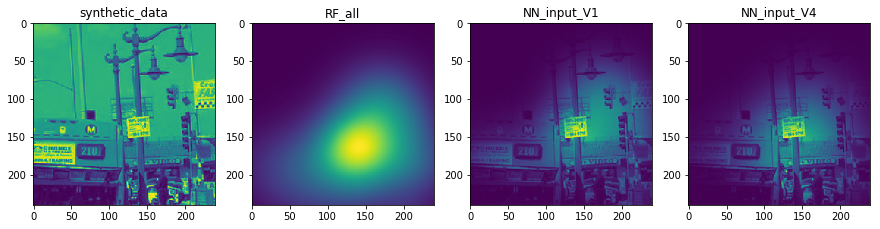

In [126]:
new_iterator = make_iterator(nn_seen, set_t, batch_size, shuffle = True)
data_indices, target_indices = next(iter(new_iterator)) #want it to be torch.Size([4, 191])
synth_signal = nn_seen[data_indices][:,:,:,:, np.newaxis].repeat(191, axis=4)
gaus = load_gausdata()

gaus_expand_to_batch = gaus.expand([len(data_indices), 191, 240, 240])
synth_signal_sum4 = synth_signal.transpose(0,4,1,2,3).sum(4)
inputs =gaus_expand_to_batch * synth_signal_sum4
inputs_V = module.select_type_inputs(inputtype, gaus_expand_to_batch, synth_signal_sum4)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.title('synthetic_data')
plt.imshow(synth_signal_sum4[0][0])
plt.subplot(1,4,2)
plt.title('RF_all')
plt.imshow(gaus_expand_to_batch[0].sum(0))
plt.subplot(1,4,3)
plt.title('NN_input_V1')
plt.imshow(inputs_V[0][0])
plt.subplot(1,4,4)
plt.title('NN_input_V4')
plt.imshow(inputs_V[0][1])
